## 0. Load libraries

In [2]:
#load libraries
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import time
import os
import datetime
import string
import matplotlib.pyplot as plt
import math
import seaborn as sns

## 1. Data gathering

### Import the WeRateDogs Twitter archive

In [26]:
archive=pd.read_csv('twitter-archive-enhanced.csv')
archive.info()
archive.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Download the Tweet Image Predictions

In [27]:
response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

open('image_predictions.tsv', 'wb').write(response.content)

335079

In [28]:
predictions = pd.read_csv('image_predictions.tsv', sep='\t')
predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Get Twitter API

In [31]:
#query Twitter API

auth = tweepy.OAuthHandler("","")
auth.set_access_token("","")
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [32]:
file = 'tweet_json.txt'
if not os.path.isfile(file):
    open(file, 'w', encoding = 'UTF-8')

In [30]:
#list of tweet ids from enhanced data set

tweet_ids = archive['tweet_id']
tweet_status=api.get_status(archive.tweet_id[7],tweet_mode='extended')

In [34]:
df_tweets =[]
df_tweets_error = []

collected =[]
not_collected = [] # to avoid error/exception messages

with open('tweet_json.txt', 'w') as file:
    for tweet_id in list(archive['tweet_id']):
        try:
            tweet_status = api.get_status(tweet_id,tweet_mode='extended')
            json.dump(tweet_status._json, file)
            file.write('\n')
            df_tweets.append(tweet_id)
        except Exception as e:
            df_tweets_error.append(tweet_id)

Rate limit reached. Sleeping for: 732
Rate limit reached. Sleeping for: 734


In [35]:
tweet_status = pd.read_json('tweet_json.txt', lines = True,encoding='utf-8')

In [39]:
df_tweets = []
dict_tweets = {}
with open('tweet_json.txt') as json_file:
    # data = json.loads(json_file)
    for line in json_file:
        data = json.loads(line)
        df_tweets.append({'tweet_id': data['id'],
                        'retweet_count': data['retweet_count'],
                        'favorite_count': data['favorite_count']})

In [40]:
df_api = pd.DataFrame(df_tweets, columns= ['tweet_id',
                                           'retweet_count',
                                           'favorite_count'])

In [41]:
df_api.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7430,35229
1,892177421306343426,5525,30494
2,891815181378084864,3647,22933
3,891689557279858688,7607,38512
4,891327558926688256,8189,36788


In [42]:
df_api.to_csv('df_tweet_json.csv')

## 2. Data Assessment

### 1) Load the data

In [3]:
df_archive=pd.read_csv('twitter-archive-enhanced.csv')
df_predictions = pd.read_csv('image_predictions.tsv', sep='\t')
df_api = pd.read_csv('df_tweet_json.csv')

### 2) Assess Archive Data

In [5]:
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [6]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [7]:
df_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [8]:
df_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [23]:
df_archive.name.value_counts()

None        603
a            55
Charlie      11
Lucy         11
Cooper       10
Oliver       10
Tucker        9
Penny         9
Winston       8
the           8
Lola          8
Sadie         8
Toby          7
Daisy         7
an            6
Koda          6
Oscar         6
Jax           6
Bo            6
Bella         6
Stanley       6
Bailey        6
Rusty         5
Buddy         5
Scout         5
Leo           5
Milo          5
Chester       5
Louis         5
Dave          5
           ... 
Lacy          1
Jarod         1
Fletcher      1
Pawnd         1
Napolean      1
Chesney       1
Bodie         1
Tess          1
Ember         1
Acro          1
Swagger       1
Jett          1
Cora          1
Socks         1
Lillie        1
Wafer         1
Brandi        1
Peanut        1
Koko          1
Lassie        1
Halo          1
Barry         1
Winifred      1
Grey          1
Margo         1
Karma         1
Balto         1
Crouton       1
Milky         1
Ronnie        1
Name: name, Length: 955,

In [ ]:
name_lower=df_archive[df_archive['name']]

#### (1) Quality issues
- 'Name' column contains words that are clearly not names(i.e. Am챕lie, a, 10).
- rating_numerator in most cases is in between 0 and 15, the rest seems like outliers.
- In most records rating_denominator is 10, and the rest seems like outliers.
- The timestamp column is string data type. It should be datetime data type.
- There are retweets and reply tweets in the table.
- 5 columns - in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp - are missing too many values.

#### (2) Tidiness issues
- One variable, the stage of dog (e.g. puppo), spread over four columns(doggo, floofer, pupper, puppo).

### 3) Assess Image predictions

In [9]:
df_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [10]:
df_predictions.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [11]:
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### (1) Quality issues
- There are some records that don't contain information about dogs.
- Only keep the confidence variable(i.e. p1) with the highest confidence rate in the predictions table.
- Remove "_" from image predicition and capitalize prediction dog breed.

#### (2) Tidiness issues
- This data(Image predictions data) should be merged with twitter archive data.

### 4) Assess API Data

In [12]:
df_api.head()

,Unnamed: 0,tweet_id,retweet_count,favorite_count
0,0,892420643555336193,7430,35229
1,1,892177421306343426,5525,30494
2,2,891815181378084864,3647,22933
3,3,891689557279858688,7607,38512
4,4,891327558926688256,8189,36788


In [13]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 4 columns):
Unnamed: 0        2331 non-null int64
tweet_id          2331 non-null int64
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(4)
memory usage: 72.9 KB


In [14]:
df_api.describe()

,Unnamed: 0,tweet_id,retweet_count,favorite_count
count,2331.000000,2.331000e+03,2331.000000,2331.000000
mean,1165.000000,7.419079e+17,2609.808237,7360.027456
std,673.046061,6.823170e+16,4415.695695,11430.241954
min,0.000000,6.660209e+17,1.000000,0.000000
25%,582.500000,6.782670e+17,528.500000,1279.000000
50%,1165.000000,7.182469e+17,1219.000000,3196.000000
75%,1747.500000,7.986692e+17,3029.000000,9009.000000
max,2330.000000,8.924206e+17,74998.000000,151730.000000


(2) Tidiness issues
- This data(api data) should be merged with twitter archive data.

## 3. Data cleansing

### 1) Clean Archive Data
#### 1-1) Quality Issues

In [83]:
archive_clean=df_archive.copy()

#### (1) 'Name' column contains words that are clearly not names(i.e. Am챕lie, a, 10).


#### Define
Replace these names to None:

['10', 'a', 'actually', 'all', 'Am챕lie', 'an', 'by', 'Dev처n', 'doggo', 'Fl찼vio', 'Fr철nq', 'getting', 'G챵rd처n', 'his', 'Iggy', 'Ike', 'incredibly', 'infuriating', 'just', 'life', 'light', 'mad', 'my', 'not', 'officially', 'old', 'Olivi챕r', 'one', 'pupper', 'quite', 'Ralph챕', 'space', 'such', 'the', 'unacceptable', 'very']

#### Code

In [84]:
archive_clean.name.replace(['10', 'a', 'actually', 'all', 'Am챕lie', 'an', 'by', 'Dev처n', 'doggo', 'Fl찼vio', 'Fr철nq', 'getting', 'G챵rd처n', 'his', 'Iggy', 'Ike', 'incredibly', 'infuriating', 'just', 'life', 'light', 'mad', 'my', 'not', 'officially', 'old', 'Olivi챕r', 'one', 'pupper', 'quite', 'Ralph챕', 'space', 'such', 'the', 'unacceptable', 'very'], np.nan, inplace=True)

#### Test

In [85]:
archive_clean.name.value_counts()

None        745
Charlie      12
Lucy         11
Oliver       11
Cooper       11
Penny        10
Lola         10
Tucker       10
Bo            9
Winston       9
Sadie         8
Buddy         7
Toby          7
Daisy         7
Bailey        7
Rusty         6
Milo          6
Jax           6
Jack          6
Scout         6
Dave          6
Oscar         6
Bella         6
Stanley       6
Leo           6
Koda          6
Oakley        5
Sammy         5
Sunny         5
George        5
           ... 
Joey          1
Boston        1
Darla         1
Ginger        1
Fwed          1
Lambeau       1
Crawford      1
Thor          1
Donny         1
Jackie        1
Oddie         1
Socks         1
Ziva          1
Lorelei       1
Holly         1
Sailer        1
Skittle       1
Sully         1
Baron         1
Amber         1
Tripp         1
Dallas        1
William       1
Karll         1
Mauve         1
Champ         1
Dobby         1
Bobb          1
Kawhi         1
Carper        1
Name: name, Length: 931,

#### (2) rating_numerator in most cases is in between 0 and 15, the rest seems like outliers.

#### Define

If rating_numerator is higer than 15, change the value to the mean of the rating_numerator. Assume that 15 is the maximum possible value.

#### Code

In [86]:
rating_numerator_mean=archive_clean['rating_numerator'].mean()
archive_clean.loc[archive_clean['rating_numerator']>15, 'rating_numerator'] = rating_numerator_mean

#### Test

In [87]:
df_archive.rating_numerator.describe()

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [88]:
archive_clean.rating_numerator.describe()

count    2356.000000
mean       10.718289
std         2.195691
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        15.000000
Name: rating_numerator, dtype: float64

I can see the mean of cleaned data is lower than dirty data.

#### (3) In most records rating_denominator is 10, and the rest seems like outliers.

#### Define

If the value of the rating denominator of all records are same as 10, it is not necessary for further analysis. So drop this column.

#### Code

In [89]:
archive_clean.drop(['rating_denominator'],axis=1,inplace=True)

#### Test

In [90]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 16 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null float64
name                          2246 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](1), float64(5), int64(1), object(9)
memory usage:

#### (4) The timestamp column is string data type. It should be datetime data type.


#### Define

Convert the timestamp column from sting data type to datetime data type.

#### Code

In [91]:
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp, errors='coerce')

#### Test

In [92]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 16 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null float64
name                          2246 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](1), float64(5), int64(1), object(9)
memory usage:

#### (5) There are retweets and reply tweets in the table.

####  Define

Remove retweets and reply tweets from the table.

#### Code

In [93]:
archive_clean = archive_clean[archive_clean.in_reply_to_status_id.isna()]
archive_clean = archive_clean[archive_clean.retweeted_status_id.isna()]

#### Test

In [94]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 16 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null datetime64[ns]
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null float64
name                          1992 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: datetime64[ns](1), float64(5), int64(1), object(9)
memory usage: 278.5+ 

#### (6) 5 columns - in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp - are missing too many values.

#### Define

Drop these columns:
[in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp]

#### Code

In [95]:
archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1, inplace=True )

#### Test

In [96]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id            2097 non-null int64
timestamp           2097 non-null datetime64[ns]
source              2097 non-null object
text                2097 non-null object
expanded_urls       2094 non-null object
rating_numerator    2097 non-null float64
name                1992 non-null object
doggo               2097 non-null object
floofer             2097 non-null object
pupper              2097 non-null object
puppo               2097 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 196.6+ KB


#### 1-2) Tidiness Issues
#### (1) One variable, the stage of dog (e.g. puppo), spread over four columns(doggo, floofer, pupper, puppo).

#### Define

Add a new column for the stage of dog and remove existing four columns(doggo, floofer, pupper, puppo).

#### Code

In [97]:
#Add a new column, 'dog_stage'
archive_clean.loc[archive_clean['doggo'] == 'doggo', 'dog_stage'] = 'doggo'
archive_clean.loc[archive_clean['floofer'] == 'floofer', 'dog_stage'] = 'floofer'
archive_clean.loc[archive_clean['pupper'] == 'pupper', 'dog_stage'] = 'pupper'
archive_clean.loc[archive_clean['puppo'] == 'puppo', 'dog_stage'] = 'puppo'

archive_clean.drop(['doggo','floofer','pupper','puppo'],axis=1, inplace=True)

#### Test

In [98]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id            2097 non-null int64
timestamp           2097 non-null datetime64[ns]
source              2097 non-null object
text                2097 non-null object
expanded_urls       2094 non-null object
rating_numerator    2097 non-null float64
name                1992 non-null object
dog_stage           336 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 147.4+ KB


### 2) Clean Image predictions data

In [99]:
predictions_clean=df_predictions.copy()

In [100]:
predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### 2-1) Quality Issues

#### (7) There are some records that don't contain information about dogs.


#### Define

Drop the records that don't contain information about dogs.

#### Code

In [101]:
not_dog=predictions_clean[predictions_clean['p1_dog']==False].index
predictions_clean=predictions_clean.drop(not_dog)

#### Test

In [102]:
predictions_clean.p1_dog.value_counts()

True    1532
Name: p1_dog, dtype: int64

#### (8) Only keep the confidence variable(i.e. p1) with the highest confidence rate in the predictions table


#### Define

Drop these columns:
['p2','p2_conf','p2_dog','p3','p3_conf','p3_dog']

#### Code

In [103]:
predictions_clean.drop(['p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'],axis=1,inplace=True)

#### Test

In [104]:
predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1532 entries, 0 to 2073
Data columns (total 6 columns):
tweet_id    1532 non-null int64
jpg_url     1532 non-null object
img_num     1532 non-null int64
p1          1532 non-null object
p1_conf     1532 non-null float64
p1_dog      1532 non-null bool
dtypes: bool(1), float64(1), int64(2), object(2)
memory usage: 73.3+ KB


#### (9) Remove "_" from image predicition and capitalize prediction dog breed.

#### Define

Remove "_" from image predicition and capitalize prediction dog breed.

#### Code

In [105]:
predictions_clean['p1']=predictions_clean['p1'].str.replace("_", ' ')
predictions_clean['p1']=predictions_clean['p1'].str.title()

#### Test

In [106]:
predictions_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311,True


####  2-2) Tidiness issues

#### (2) This data(Image predictions data) should be merged with twitter archive data.

#### Define

Merge Image predictions data with twitter archive data.

#### Code

In [107]:
twitter_archive_master = pd.merge(archive_clean,predictions_clean,how='left',on='tweet_id')

#### Test

In [108]:
twitter_archive_master.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,dog_stage,jpg_url,img_num,p1,p1_conf,p1_dog
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,Phineas,NaN,NaN,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,Darla,NaN,NaN,NaN,NaN,NaN,NaN
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,Basset,0.555712,True


### 3) Clean Twitter API Data

In [109]:
API_clean=df_api.copy()

#### 3-1) Quality issues

There is no quality issues identified.

#### 3-2) Tidiness issues

(3) This data(api data) should be merged with twitter archive data.

#### Define

Merge Twitter API data with twitter master data.

#### Code

In [110]:
twitter_archive_master = pd.merge(twitter_archive_master,API_clean,how='left',on='tweet_id')

#### Test

In [111]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 16 columns):
tweet_id            2097 non-null int64
timestamp           2097 non-null datetime64[ns]
source              2097 non-null object
text                2097 non-null object
expanded_urls       2094 non-null object
rating_numerator    2097 non-null float64
name                1992 non-null object
dog_stage           336 non-null object
jpg_url             1463 non-null object
img_num             1463 non-null float64
p1                  1463 non-null object
p1_conf             1463 non-null float64
p1_dog              1463 non-null object
Unnamed: 0          2090 non-null float64
retweet_count       2090 non-null float64
favorite_count      2090 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(1), object(8)
memory usage: 278.5+ KB


### 4) Store the final dataframe

In [112]:
#1. Store the master data
twitter_archive_master.to_csv('twitter_archive_master.csv',header=True, index=False, encoding='utf-8')

#2. Store the cleaned twitter archive
df_archive.to_csv('twitter-archive-enhanced_cleaned.csv',header=True, index=False, encoding='utf-8')

#3. Store the cleaned image predictions
df_predictions.to_csv('image-predictions_cleaned.csv',header=True, index=False, encoding='utf-8')

## 4. Analyzing and Visualizing Data

#### 0) Import the master data

In [113]:
df_master=pd.read_csv('twitter_archive_master.csv')
df_master.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,dog_stage,jpg_url,img_num,p1,p1_conf,p1_dog,Unnamed: 0,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,Phineas,NaN,NaN,NaN,NaN,NaN,NaN,0.0,7430.0,35229.0
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,1.0,5525.0,30494.0
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True,2.0,3647.0,22933.0
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,Darla,NaN,NaN,NaN,NaN,NaN,NaN,3.0,7607.0,38512.0
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,Basset,0.555712,True,4.0,8189.0,36788.0


### 1) Favorite counts and retweet counts by dog stage

Draw a bar chart to see the frequency of tweets by dog stage.

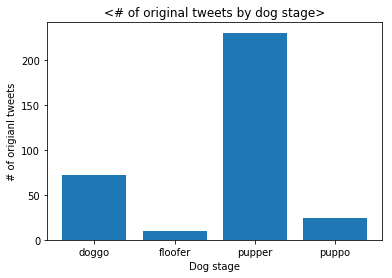

In [114]:
dog_stage_count=df_master.groupby('dog_stage').tweet_id.count()

label = ['doggo', 'floofer', 'pupper', 'puppo']
index = np.arange(len(label))

plt.bar(index, dog_stage_count)
plt.title('<# of original tweets by dog stage>')
plt.xlabel('Dog stage')
plt.ylabel('# of origianl tweets')
plt.xticks(index, label)
plt.show()

Since the number of original tweets of each dog stage is different, calculate and compare the mean of favorit counts and retweet counts by dog stage.

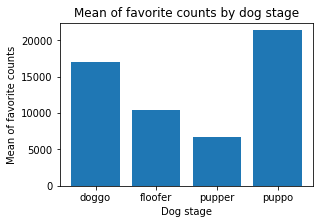

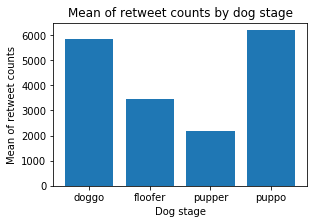

In [115]:
# Calculate the mean of favorite counts and retweet counts by dog stage

dog_stage_fav_mean=df_master.groupby('dog_stage').favorite_count.mean()
dog_stage_ret_mean=df_master.groupby('dog_stage').retweet_count.mean()

# Visualize the mean of favorite counts and retweet counts by dog stage


plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
label = ['doggo', 'floofer', 'pupper', 'puppo']
index = np.arange(len(label))

plt.bar(index, dog_stage_fav_mean)
plt.title('Mean of favorite counts by dog stage')
plt.xlabel('Dog stage')
plt.ylabel('Mean of favorite counts')
plt.xticks(index, label)
plt.show()

plt.figure(figsize=(10,3))
plt.subplot(1,2,2)
label = ['doggo', 'floofer', 'pupper', 'puppo']
index = np.arange(len(label))

plt.bar(index, dog_stage_ret_mean)
plt.title('Mean of retweet counts by dog stage')
plt.xlabel('Dog stage')
plt.ylabel('Mean of retweet counts')
plt.xticks(index, label)
plt.show()

While WeRateDog uploaded the picture of pupper most, the tweets about Puppo got the highest number of favorite and the retweet on average.

### 2) Top rated dog stage

Calculate the average rating by dog stage.

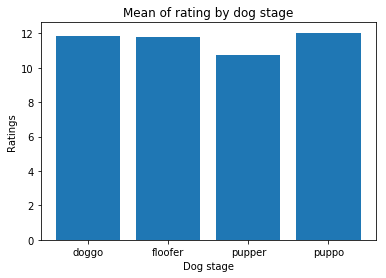

dog_stage
doggo      11.847222
floofer    11.800000
pupper     10.757072
puppo      12.041667
Name: rating_numerator, dtype: float64

In [116]:
dog_stage_rating_mean=df_master.groupby('dog_stage').rating_numerator.mean()
dog_stage_rating_mean

label = ['doggo', 'floofer', 'pupper', 'puppo']
index = np.arange(len(label))

plt.bar(index, dog_stage_rating_mean)
plt.title('Mean of rating by dog stage')
plt.xlabel('Dog stage')
plt.ylabel('Ratings')
plt.xticks(index, label)
plt.show()

dog_stage_rating_mean

The ratings were high in order Puppo, Doggo, Floofer, and Pupper.

### 3) Most popular and Least popular breed 

Check 5 breeds which got the most 'favorites' and got the least 'favorites' each.

In [117]:
breed_fav_sum=df_master.groupby('p1').favorite_count.sum()

df_breed_fav_sum=breed_fav_sum.to_frame()
df_breed_fav_sum.columns=['favorite_count']
df_breed_fav_sum_f=df_breed_fav_sum.reset_index()

In [118]:
breed_fav_top5=df_breed_fav_sum_f.sort_values(by='favorite_count',ascending=False)[0:5]

breed_fav_top5

,p1,favorite_count
44,Golden Retriever,1537895.0
60,Labrador Retriever,959180.0
78,Pembroke,905191.0
26,Chihuahua,623405.0
86,Samoyed,467050.0


Golden Retreiver got the favorites the most, followed by Labrador Retriever, Pembroke, Chihuahua and Samoyed.

In [119]:
breed_fav_least5=df_breed_fav_sum_f.sort_values(by='favorite_count',ascending=False)[-5:]

breed_fav_least5

,p1,favorite_count
37,Entlebucher,2377.0
19,Brabancon Griffon,2347.0
97,Standard Schnauzer,1785.0
49,Groenendael,1695.0
55,Japanese Spaniel,1175.0


On the other hand, the number of favorites was low in order Japanese Spaniel, Groenendael, Standard Schnauzer, Brabancon Griffon and Entlebucher.